In [1]:
import numpy as np
import pandas as pd
import os
import pprint
import sklearn
from sklearn import preprocessing
from sklearn.decomposition import PCA
import warnings
import matplotlib
from os import listdir
import seaborn as sns
import scipy
import sys
import pickle
import miceforest as mf
warnings.filterwarnings("ignore")
import functools
from functools import reduce
from mc4.algorithm import mc4_aggregator
from copy import deepcopy

import sklearn.neighbors._base
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base

from sklearn.preprocessing import StandardScaler, MinMaxScaler
import missingpy
from sklearn.experimental import enable_iterative_imputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import brier_score_loss, precision_score, recall_score, f1_score, log_loss, roc_auc_score
from collections import Counter
import torch
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import NearMiss
from collections import Counter

import shap
import matplotlib.pyplot as plt
import statsmodels.api as sm
from torch.utils.data import Dataset, DataLoader

In [2]:
rs = 42

In [3]:
import random

def _init_fn(worker_id):
    np.random.seed(int(rs))
    
def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

seed_torch()

In [4]:
# Undersample Test Set
test_under_sampler = 0
do_class_weight = 1

# Undersample Train Set
do_smote = 0
do_random_under_sampler = 0
do_random_over_sampler = 0
do_tomek_links = 0
do_near_miss = 0

In [5]:
def find_csv_filenames( path_to_dir, suffix=".csv" ):
    filenames = listdir(path_to_dir)
    return [ filename for filename in filenames if filename.endswith( suffix ) ]

In [6]:
os.chdir('..')

In [7]:
prediction_window = ""

In [8]:
data_directory = 'Sepsis Data/'
prediction_directory = 'sepsis/'

data_files = find_csv_filenames(data_directory+prediction_directory)

hosps = [x.replace('.csv', '') for x in data_files]

In [9]:
model_directory = 'Sepsis Models/' + prediction_window + '/Pytorch LR/'

#### Loading Cleaned Data

In [10]:
def get_features_diag(data):
    features = list(data_dictionary[hosp])
    features.remove(list(data_dictionary[hosp])[-1])
    AKI_diag = list(data_dictionary[hosp])[-1]
    return features, AKI_diag

def do_training_modifications(X_train, y_train):
    if do_smote:
        oversample = SMOTE(random_state=rs)
        X_train, y_train = oversample.fit_resample(X_train, y_train)
    if do_random_under_sampler:
        rus = RandomUnderSampler(replacement=True, random_state=rs)
        X_train, y_train = rus.fit_resample(X_train, y_train)
    if do_random_over_sampler:
        ros = RandomOverSampler(random_state=rs)
        X_train, y_train = ros.fit_resample(X_train, y_train)
    if do_tomek_links:
        tl = TomekLinks(random_state=rs)
        X_train, y_train = tl.fit_resample(X_train, y_train)
    if do_near_miss:
        nm = NearMiss(random_state=rs)
        X_train, y_train = nm.fit_resample(X_train, y_train)  
    return X_train, y_train

def normalize_data(data_dictionary, hosp):
    df = deepcopy(data_dictionary[hosp])
    demographic_index = list(df).index('is_female')
    medical_signs = list(df)[:demographic_index]
    medication_index = list(df).index('ACETAMIN')
    medications = list(df)[medication_index:len(list(data))-1]
    demographic_binary = ['is_female', 'race_black', 'race_hispanic', 'race_asian', 
                        'race_other', 'electivesurgery']
    binary_features = medications + demographic_binary
    continuous_features = medical_signs + ['age', 'BMI']

    df[continuous_features] = (df[continuous_features]-df[continuous_features].mean())/df[continuous_features].std()
    df[binary_features] = df[binary_features].replace([0],-1)
    return df

In [11]:
temp_data_dictionary = dict.fromkeys(hosps)
data_dictionary = dict.fromkeys(hosps)
missing_dictionary = dict.fromkeys(hosps)

In [62]:
for hosp in data_dictionary:
    file = str(hosp) + '.csv'
    data = pd.read_csv(data_directory + prediction_directory + "cleaned/" + file)
    data = data.loc[:, ~data.columns.str.contains('^Unnamed')]
    data_dictionary[hosp] = data
    
for hosp in temp_data_dictionary:
    file = str(hosp) + '.csv'
    data = pd.read_csv(data_directory + prediction_directory + "cleaned/unscaled/" + file)
    data = data.loc[:, ~data.columns.str.contains('^Unnamed')]
    temp_data_dictionary[hosp] = data

In [63]:
for hosp in data_dictionary:
    data_dictionary[hosp] = normalize_data(data_dictionary, hosp)

#### Functions for Model Training and Validation

In [14]:
class LR(nn.Module):
    def __init__(self,input_shape):
        super(LR,self).__init__()
        self.fc1 = nn.Linear(input_shape,1)
    
    def forward(self,x):
        x = torch.sigmoid(self.fc1(x))
        return x
    
    def fit(self, X_train, y_train, epochs=200, lr=0.01, batch_size=64):
        X_train = X_train.values
        y_train = y_train.values
        class_weights = sklearn.utils.compute_class_weight('balanced', classes=np.unique(np.squeeze(y_train)),
                                                           y=np.squeeze(y_train))
        trainset = dataset(X_train, y_train)
        train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers = 0, worker_init_fn=_init_fn)
        criterion = nn.BCELoss()
        optimizer = torch.optim.SGD(self.parameters(), lr=lr)
        self.train_model(train_loader, criterion, optimizer, epochs, class_weights)
        return self
    
    def predict_prob(self, X):
        with torch.no_grad():
            return np.array(self(torch.tensor(X,dtype=torch.float32)).flatten())
        
    def get_predictions(self, X_test):
        with torch.no_grad():
            predicted = self(torch.tensor(X_test,dtype=torch.float32))
            predictions_one_encoded = predicted.reshape(-1).detach().numpy().round()
            return np.array(predicted).flatten(), predictions_one_encoded
        
    def train_model(self, train_loader, criterion, optimizer, epochs, class_weights):
        for i in range(epochs):
            for j,(x_train,y_train) in enumerate(train_loader):
                #calculate output
                output = self(x_train)
                # set criterion weight
                batch_class_weights = y_train.clone().detach()
                batch_class_weights[batch_class_weights == 0] = class_weights[0]
                batch_class_weights[batch_class_weights == 1] = class_weights[1]
                criterion.weight = batch_class_weights.reshape(-1,1)
                #calculate loss
                loss = criterion(output,y_train.reshape(-1,1))
                #backprop
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
    
class dataset(Dataset):
    def __init__(self,x,y):
        self.x = torch.tensor(x,dtype=torch.float32)
        self.y = torch.tensor(y,dtype=torch.float32)
        self.length = self.x.shape[0]
    def __getitem__(self,idx):
        return self.x[idx],self.y[idx]
    def __len__(self):
        return self.length    


In [15]:
def evaluate_model_optim(model, y_test, X_test, print_dist=False):
    y_test = y_test.values
    probs, predictions = model.get_predictions(X_test.values)
    y_pred_coded = predictions
    probs = probs.flatten()
    if print_dist == True:
        print("Distribution of Test Predictions")
        pred_class_distribution(y_test, y_pred_coded)
        print("###########")
    metric=[]
    metric.append(['accuracy',np.round(accuracy_score(y_test,y_pred_coded), 3)])
    roc_score = np.round(roc_auc_score(y_test, probs), 3)
    metric.append(['roc',np.round(roc_score, 3)])
    metric.append(['precision',np.round(precision_score(y_test,y_pred_coded), 3)])
    metric.append(['recall',np.round(recall_score(y_test,y_pred_coded), 3)])
    return metric

def pred_class_distribution(y_test, y_pred_coded):
    zero_wrong, zero_right, one_wrong, one_right = [0] * 4
    for i in range(0, len(y_pred_coded)):
        if y_test[i] == 0:
            if y_pred_coded[i] == 0:
                zero_right += 1
            else:
                zero_wrong += 1
        if y_test[i] == 1:
            if y_pred_coded[i] == 1:
                one_right += 1
            else:
                one_wrong += 1
    print("Number of 0 Class Predictions Right: " + str(zero_right))
    print("Number of 0 Class Predictions Wrong: " + str(zero_wrong))
    print("Number of 1 Class Predictions Right: " + str(one_right))
    print("Number of 1 Class Predictions Wrong: " + str(one_wrong))

In [16]:
def get_cross_validated_scores(X, Y, partial_fit=False, model_name=None, model=None):
    cv = sklearn.model_selection.StratifiedKFold(n_splits=5,shuffle=True, random_state=rs)
    
    accs = []
    aucs = []
    precs = []
    recs = []
    macro_predictions = []
    macro_test = []
    count = 1
    for train, test in cv.split(X, Y):
        if partial_fit:
            if model == None:
                raise ValueError('Need to have a model to train from')
            clf = deepcopy(model)
            X_train = X.iloc[train]
            y_train = Y.iloc[train]
            clf = clf.fit(X_train, y_train)
            filename = model_directory + model_name + '_CV' + str(count) + '.pckl'
            pickle.dump(clf, open(filename, 'wb'))
            probs, y_pred_coded = clf.get_predictions(X.iloc[test].values)
        else:
            input_size = X.shape[1]
            model = LR(input_size)
            X_train = X.iloc[train]
            y_train = Y.iloc[train]
            model = model.fit(X_train, y_train, epochs=200, lr=0.01)
            filename = model_directory + model_name + '_CV' + str(count) + '.pckl'
            pickle.dump(model, open(filename, 'wb'))
            probs, y_pred_coded = model.get_predictions(X.iloc[test].values)
        fpr, tpr, t = sklearn.metrics.roc_curve(Y.iloc[test].values, probs)
        macro_predictions.append(probs)
        macro_test.append(Y.iloc[test].values)
        acc = accuracy_score(Y.iloc[test].values, y_pred_coded)
        roc_auc = sklearn.metrics.auc(fpr, tpr)
        prec = precision_score(Y.iloc[test].values,y_pred_coded)
        rec = recall_score(Y.iloc[test].values,y_pred_coded)
        aucs.append(roc_auc), accs.append(acc), precs.append(prec), recs.append(rec)
        count += 1
    
    # Macro AUC-ROC
    all_predictions = np.concatenate(macro_predictions, axis=0)
    all_test = np.concatenate(macro_test, axis=0)
    fpr, tpr, t = sklearn.metrics.roc_curve(all_test, all_predictions)
    roc_info = [fpr, tpr, t]
    # find_best_threshold(t, fpr, tpr)
    
    # Calculating Cross Fold Metrics
    metric = []
    stds = []
    mean_acc = np.round(np.mean(np.array(accs)), 3)
    mean_auc = np.round(np.mean(np.array(aucs)), 3)
    mean_prec = np.round(np.mean(np.array(precs)), 3)
    mean_rec = np.round(np.mean(np.array(recs)), 3)
    metric.append(['accuracy', mean_acc]), metric.append(['roc', mean_auc])
    metric.append(['prec', mean_prec]), metric.append(['rec', mean_rec])
    std_acc = np.round(np.std(np.array(accs)), 3)
    std_auc = np.round(np.std(np.array(aucs)), 3)
    std_prec = np.round(np.std(np.array(precs)), 3)
    std_rec = np.round(np.std(np.array(recs)), 3)
    stds.append(['accuracy', std_acc]), stds.append(['roc', std_auc])
    stds.append(['prec', std_prec]), stds.append(['rec', std_rec])
    return metric, stds, roc_info

In [17]:
def get_pooled_cross_validated_scores(hosps, model_name='Agg'):
    splits = 5
    cv = sklearn.model_selection.StratifiedKFold(n_splits=splits,shuffle=True, random_state=rs)
    
    all_accs = []
    all_aucs = []
    all_precs = []
    all_recs = []
    all_macro_predictions = []
    all_macro_test = []
    
    for split_count in range(splits):    
        X_training_dictionary = dict.fromkeys(hosps)
        X_testing_dictionary = dict.fromkeys(hosps)
        y_training_dictionary = dict.fromkeys(hosps)
        y_testing_dictionary = dict.fromkeys(hosps)

        for hosp in data_dictionary:
            data = data_dictionary[hosp]
            features, AKI_diag = get_features_diag(data)
            X = data[features]
            Y = data[AKI_diag]
            train, test = get_fold_info(split_count, cv.split(X, Y))
            X_training_dictionary[hosp] = X.iloc[train]
            X_testing_dictionary[hosp] = X.iloc[test]
            y_training_dictionary[hosp] = Y.iloc[train]
            y_testing_dictionary[hosp] = Y.iloc[test]
        
        input_size = len(features)
        X_train = pd.concat(X_training_dictionary.values())
        y_train = pd.concat(y_training_dictionary.values())
        model = LR(input_size)
        X_train = X.iloc[train]
        y_train = Y.iloc[train]
        model = model.fit(X_train, y_train, epochs=200, lr=0.01, batch_size=256)
        filename = model_directory + model_name + '_CV' + str(split_count+1) + '.pckl'
        pickle.dump(model, open(filename, 'wb'))
        
        accs = []
        aucs = []
        precs = []
        recs = []
        macro_predictions = []
        macro_test = []
        
        for hosp in hosps:
            probs, y_pred_coded = model.get_predictions(X_testing_dictionary[hosp].values)
            fpr, tpr, t = sklearn.metrics.roc_curve(y_testing_dictionary[hosp].values, probs)
            acc = accuracy_score(y_testing_dictionary[hosp].values, y_pred_coded)
            roc_auc = sklearn.metrics.auc(fpr, tpr)
            prec = precision_score(y_testing_dictionary[hosp].values,y_pred_coded)
            rec = recall_score(y_testing_dictionary[hosp].values,y_pred_coded)
            aucs.append(roc_auc), accs.append(acc), precs.append(prec), recs.append(rec)
            macro_predictions.append(probs)
            macro_test.append(y_testing_dictionary[hosp].values)

        all_accs.append(accs), all_aucs.append(aucs), all_precs.append(precs), all_recs.append(recs)
        all_macro_predictions.append(np.array(macro_predictions)), all_macro_test.append(np.array(macro_test))
    
    all_accs = np.array(all_accs)
    all_aucs = np.array(all_aucs)
    all_precs = np.array(all_precs)
    all_recs = np.array(all_recs)
    all_macro_predictions = np.array(all_macro_predictions)
    all_macro_test = np.array(all_macro_test)
    
    metrics_dictionary = dict.fromkeys(hosps)
    stds_dictionary = dict.fromkeys(hosps)
    roc_info_dictionary = dict.fromkeys(hosps)
    
    for i, hosp in enumerate(hosps):
        metric = []
        stds = []
        mean_acc = np.round(np.mean(all_accs[:, i]), 3)
        mean_auc = np.round(np.mean(all_aucs[:, i]), 3)
        mean_prec = np.round(np.mean(all_precs[:, i]), 3)
        mean_rec = np.round(np.mean(all_recs[:, i]), 3)
        metric.append(['accuracy', mean_acc]), metric.append(['roc', mean_auc])
        metric.append(['prec', mean_prec]), metric.append(['rec', mean_rec])
        std_acc = np.round(np.std(all_accs[:, i]), 3)
        std_auc = np.round(np.std(all_aucs[:, i]), 3)
        std_prec = np.round(np.std(all_precs[:, i]), 3)
        std_rec = np.round(np.std(all_recs[:, i]), 3)
        stds.append(['accuracy', std_acc]), stds.append(['roc', std_auc])
        stds.append(['prec', std_prec]), stds.append(['rec', std_rec])
        metrics_dictionary[hosp] = metric
        stds_dictionary[hosp] = stds
        
        roc_info = []
        all_predictions = np.concatenate(all_macro_predictions[:, i])
        all_test = np.concatenate(all_macro_test[:, i])
        fpr, tpr, t = sklearn.metrics.roc_curve(all_test, all_predictions)
        roc_info = [fpr, tpr, t]
        roc_info_dictionary[hosp] = roc_info
    
    return metrics_dictionary, stds_dictionary, roc_info_dictionary


def get_fold_info(split_count, gen):
    j = 0
    for train, test in gen:
        train = train
        test = test
        if split_count == j:
            break
        j += 1
    return train, test

In [18]:
def display_metrics(metrics, stand_dev = None):
    if stand_dev is None:
        print("Accuracy: {}".format(metrics[0][1]))
        print("AUC: {}".format(metrics[1][1]))
        print("Precision: {}".format(metrics[2][1]))
        print("Recall: {}".format(metrics[3][1]))
    else:
        s_acc = str(metrics[0][1]) + " ± " + str(stand_dev[0][1])
        s_auc = str(metrics[1][1]) + " ± " + str(stand_dev[1][1])
        s_prec = str(metrics[2][1]) + " ± " + str(stand_dev[2][1])
        s_rec = str(metrics[3][1]) + " ± " + str(stand_dev[3][1])
        print("Accuracy: " + s_acc)
        print("AUC: " + s_auc)
        print("Precision: " + s_prec)
        print("Recall: " + s_rec)
#         print(s_acc)
#         print(s_auc)
#         print(s_prec)
#         print(s_rec)

#### Local Models

In [ ]:
local_models = dict.fromkeys(hosps)
local_models_performances = dict.fromkeys(hosps) 
local_models_stds = dict.fromkeys(hosps) 
local_models_roc_info = dict.fromkeys(hosps) 

In [ ]:
for i, hosp in enumerate(data_dictionary):
    data = data_dictionary[hosp]
    features, AKI_diag = get_features_diag(data)
    X = data[features]
    Y = data[AKI_diag]
    
    metrics, stds, roc_info = get_cross_validated_scores(X, Y, model_name=hosp)
    
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=rs)
    
    input_size = X_train.shape[1]
    model = LR(input_size)
    
    model = model.fit(X_train, y_train, epochs=200, lr=0.01)
    
    filename = model_directory + hosp + '_full.pckl'
    pickle.dump(model, open(filename, 'wb'))
    
    local_models[hosp] = model
    local_models_performances[hosp] = metrics
    local_models_stds[hosp] = stds
    local_models_roc_info[hosp] = roc_info
    print("Done with " + str(i+1) + " out of " + str(len(data_dictionary)) + " models", end="\r")
    
print("Finished Training all Models")

In [ ]:
for hosp in local_models_performances:
    print("Performance of Hosp {}:".format(hosp))
    display_metrics(local_models_performances[hosp], stand_dev = local_models_stds[hosp])
    print("\n")

In [ ]:
filename = model_directory + 'LocalModelPerformances.pckl'
pickle.dump([local_models_performances, local_models_stds, local_models_roc_info], open(filename, 'wb'))

#### Aggregated Model

In [ ]:
agg_data = pd.concat(data_dictionary.values())

features, AKI_diag = get_features_diag(agg_data)
X = agg_data[features]
Y = agg_data[AKI_diag]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=rs)

metrics_dictionary, stds_dictionary, roc_info_dictionary = get_pooled_cross_validated_scores(hosps, model_name="Agg")

input_size = X_train.shape[1]
model = LR(input_size)

model = model.fit(X_train, y_train, epochs=200, lr=0.01)

filename = model_directory + 'Agg_full.pckl'
pickle.dump(model, open(filename, 'wb'))

agg_model = model

evaluate_model_optim(agg_model, y_test, X_test, print_dist=True)

In [ ]:
for hosp in hosps:
    print("Performance of Hosp {}:".format(hosp))
    display_metrics(metrics_dictionary[hosp], stand_dev = stds_dictionary[hosp])
    print("\n")

In [ ]:
filename = model_directory + 'AggLocalModelPerformances.pckl'
pickle.dump([metrics_dictionary, stds_dictionary, roc_info_dictionary], open(filename, 'wb'))

### Model Feature Importances

In [19]:
def load_cv_models(hosp):
    cv_models = []
    for i in range(0, 5):
        fold = i + 1
        filename = model_directory + hosp + '_CV' + str(fold) + ".pckl"
        model = pickle.load(open(filename, 'rb'))
        cv_models.append(model)
    return cv_models

### SHAP

In [20]:
calculate_shap_importances = 1
import caffeine
caffeine.on(display=False)

In [21]:
def get_shap_feature_rankings(hosp):
    cv_models = load_cv_models(hosp)
    df_folds = []
    for shap_model in cv_models:
        if hosp == 'Agg':
            features, AKI_diag = get_features_diag(agg_data)
            X = agg_data[features]
            Y = agg_data[AKI_diag]
        else:
            data = data_dictionary[hosp]
            features, AKI_diag = get_features_diag(data)
            X = data[features]
            Y = data[AKI_diag]
        explainer = shap.KernelExplainer(shap_model.predict_prob, shap.sample(X, 100))
        shap_values = explainer.shap_values(shap.sample(X, 200)) #Reducing sample size b/c of how long it takes
        vals = np.abs(shap_values)
        temp = pd.DataFrame(list(zip(X.columns, sum(vals))), columns=['col_name','feature_importance_vals'])
        temp.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
        temp = temp.set_index('col_name')
        col_name = 'feature_importance_vals'
        min_value = temp[col_name].min()
        temp1 = temp[temp[col_name] > min_value]
        temp2 = temp[temp[col_name] == min_value]
        temp1[col_name] = temp1[col_name].rank(ascending=False)
        temp2[col_name] = temp1[col_name].max() + 1
        temp = pd.concat([temp1, temp2]).astype(int)
        df_folds.append(temp)
    df_final = reduce(lambda left,right: pd.merge(left,right, left_index=True, right_index=True), df_folds)
    imp_features = mc4_aggregator(df_final, header_row = 0, index_col = 0) 
    imp_features = dict(sorted(imp_features.items(), key=lambda item: item[1]))
    a = np.array(list(imp_features.items()))[:, 0]
    return a

#### Local Models

In [22]:
if calculate_shap_importances:
    local_shap_values = dict.fromkeys(hosps)
    local_shap_features = dict.fromkeys(hosps)
    local_shap_explainers = dict.fromkeys(hosps)
    local_X = dict.fromkeys(hosps)

In [23]:
if calculate_shap_importances:
    for i, hosp in enumerate(data_dictionary):
        data = data_dictionary[hosp]
        features, AKI_diag = get_features_diag(data)

        X = data[features]
        Y = data[AKI_diag]
        
        input_size = X.shape[1]
        shap_model = LR(input_size)
        shap_model = shap_model.fit(X, Y, epochs=200, lr=0.01)

        explainer = shap.KernelExplainer(shap_model.predict_prob, shap.sample(X, 100))
        shap_values = explainer.shap_values(shap.sample(X, 1000))

        local_shap_explainers[hosp] = explainer
        local_shap_values[hosp] = shap_values
        local_X[hosp] = X

        vals = np.abs(shap_values)
        feature_importance = pd.DataFrame(list(zip(X.columns, sum(vals))), columns=['col_name','feature_importance_vals'])
        feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)

        local_shap_features[hosp] = feature_importance
        print("Done with " + str(i+1) + " out of " + str(len(data_dictionary)) + " hospitals", end="\r")

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

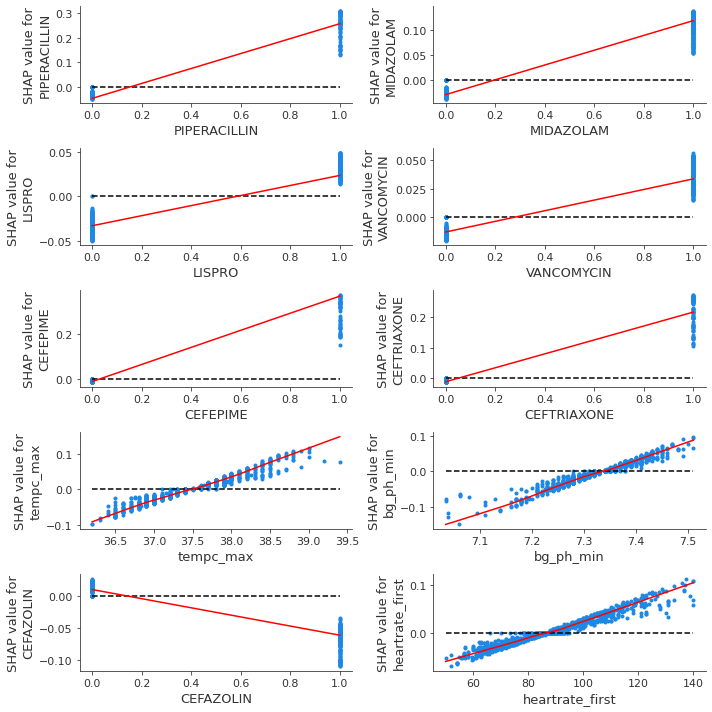

In [30]:
if calculate_shap_importances:
    # Using One Specific Hospital
    hosp = "420"
    num_rows = 5
    num_cols = 2
    df_temp = pd.read_csv("Sepsis Code/Feature Importances/Pytorch LR_" + prediction_window + "_SHAPImportantFeatures.csv")
    top_features = (df_temp[hosp].values)[0:10]
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(10,10))
    for i, feature in enumerate(top_features):
        idx = np.where(local_X[hosp].columns==feature)[0][0]
        unscaled_X = temp_data_dictionary[hosp][features]
        x = shap.sample(unscaled_X, 1000).iloc[:,idx]
        y_sv = local_shap_values[hosp][:,idx]
        lowess = sm.nonparametric.lowess(y_sv, x, frac=.3)
        ax = axes[divmod(i, num_cols)]
        ax.hlines(y=0, xmin=np.min(x), xmax=np.max(x), linestyles='dashed', color='black')
        ax.plot(*list(zip(*lowess)), color="red", )
        shap.dependence_plot(feature, local_shap_values[hosp], shap.sample(unscaled_X, 1000), ax=ax, show=False,
                             interaction_index=None)
    fig.tight_layout()

#### Aggregated Model

In [27]:
if calculate_shap_importances:
    agg_data = pd.concat(data_dictionary.values())
    features, AKI_diag = get_features_diag(agg_data)
    X = agg_data[features]
    Y = agg_data[AKI_diag]
    
    input_size = X.shape[1]
    shap_model = LR(input_size)
    shap_model = shap_model.fit(X, Y, epochs=200, lr=0.01)

    explainer_agg = shap.KernelExplainer(shap_model.predict_prob, shap.sample(X, 100))
    shap_values_agg = explainer_agg.shap_values(shap.sample(X, 1000))

    vals = np.abs(shap_values_agg)
    agg_feature_importance = pd.DataFrame(list(zip(X.columns, sum(vals))), columns=['col_name','feature_importance_vals'])
    agg_feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

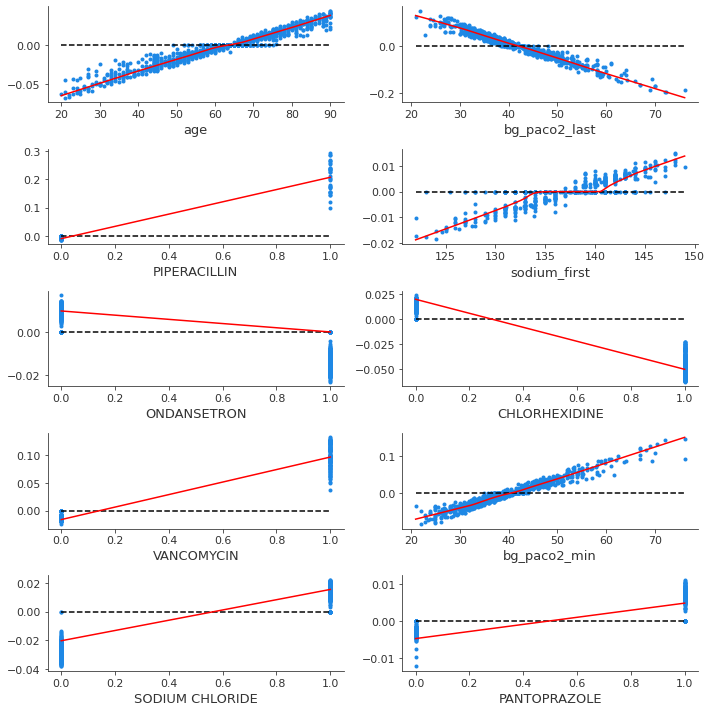

In [31]:
if calculate_shap_importances:
    num_rows = 5
    num_cols = 2
    df_temp = pd.read_csv("Sepsis Code/Feature Importances/Pytorch LR_" + prediction_window + "_SHAPImportantFeatures.csv")
    top_features = (df_temp['Agg'].values)[0:10]
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(10,10))
    for i, feature in enumerate(top_features):
        idx = np.where(X.columns==feature)[0][0]
        unscaled_agg_data = pd.concat(temp_data_dictionary.values())
        unscaled_X = unscaled_agg_data[features]
        x = shap.sample(unscaled_X, 1000).iloc[:,idx]
        y_sv = shap_values_agg[:,idx]
        lowess = sm.nonparametric.lowess(y_sv, x, frac=.3)
        ax = axes[divmod(i, num_cols)]
        ax.hlines(y=0, xmin=np.min(x), xmax=np.max(x), linestyles='dashed', color='black')
        ax.plot(*list(zip(*lowess)), color="red", )
        shap.dependence_plot(feature, shap_values_agg, shap.sample(unscaled_X, 1000), ax=ax, show=False,
                             interaction_index=None)
        ax.set(ylabel=None)
    fig.tight_layout()

In [50]:
if calculate_shap_importances:
    filename = 'Sepsis Code/Feature Importances/Pytorch LR_Feat_Dicts.pckl'
    information = [local_shap_explainers, local_shap_values, local_X, explainer_agg, shap_values_agg]
    pickle.dump(information, open(filename, 'wb'), protocol=5)

##### Making CSV File for SHAP Feature Importances

In [ ]:
# if calculate_shap_importances:
#     shap_feat_imp_dfs = []
#     for hosp in local_shap_features:
#         temp_df = local_shap_features[hosp].set_index('col_name')
#         temp_df = temp_df.rename(columns={"feature_importance_vals": hosp})
#         shap_feat_imp_dfs.append(temp_df)

#     temp_df = agg_feature_importance.set_index('col_name')
#     temp_df = temp_df.rename(columns={"feature_importance_vals": "Agg"})
#     shap_feat_imp_dfs.append(temp_df)
#     df_shap_feat_imps_scores = pd.concat(shap_feat_imp_dfs, axis=1)
#     df_shap_feat_imps_scores.to_csv("Sepsis Code/Feature Importances/Pytorch LR_" + prediction_window + "_SHAPFeatureImportanceScores.csv")

In [ ]:
if calculate_shap_importances:
    comb_hosps = hosps + ["Agg"]
    shap_top_features = dict.fromkeys(comb_hosps)
    for i, hosp in enumerate(comb_hosps):
        top_features = get_shap_feature_rankings(hosp)
        shap_top_features[hosp] = top_features
        print("Done with " + str(i+1) + " out of " + str(len(comb_hosps)) + " hospitals", end="\r")

    shap_top_df = pd.DataFrame(shap_top_features)
    shap_top_df.to_csv("Sepsis Code/Feature Importances/Pytorch LR_" + prediction_window + "_SHAPImportantFeatures.csv")

In [ ]:
if calculate_shap_importances:
    shap_top_df.head(20)

In [ ]:
caffeine.off()

### Transporting and Refitting Model from Source to Site

- Source: Institution X

In [ ]:
source_hosp = "252"
site_hosps = [x for x in hosps if x != source_hosp]
site_models_transported_performance = dict.fromkeys(site_hosps)
site_models_refitted = dict.fromkeys(site_hosps)
site_models_refitted_performance = dict.fromkeys(site_hosps)

In [ ]:
for i, site_hosp in enumerate(site_hosps):
    source_model = local_models[source_hosp]
    site_data = data_dictionary[site_hosp]
    features, AKI_diag = get_features_diag(site_data)
    
    X = site_data[features]
    Y = site_data[AKI_diag]
    site_models_transported_performance[site_hosp] = evaluate_model_optim(source_model, Y, X, print_dist=False)
    
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=rs)
    
    metrics, stds, roc_info = get_cross_validated_scores(X_train, y_train, partial_fit=True,
                                               model_name="Refitted_" + hosp, model=source_model)
    site_models_refitted_performance[site_hosp] = metrics

    new_model = deepcopy(source_model)
    refit_model = new_model.fit(X_train, y_train)

    site_models_refitted[site_hosp] = refit_model
    print("Done with " + str(i+1) + " out of " + str(len(site_hosps)) + " hospitals", end="\r")
    
print("Finished Training all Models")

In [ ]:
site_transported_auc_drops = []
site_refitted_auc_drops = []
for site_hosp in site_hosps:
    trans_drop = local_models_performances[site_hosp][1][1] - site_models_transported_performance[site_hosp][1][1]
    site_transported_auc_drops.append(trans_drop)
    refit_drop = local_models_performances[site_hosp][1][1] - site_models_refitted_performance[site_hosp][1][1]
    site_refitted_auc_drops.append(refit_drop)

# Add source hospital AUC drop of 0
site_transported_auc_drops.append(0)
site_refitted_auc_drops.append(0)

## Getting Transportability Metrics

In [ ]:
def initialize_metric_dictionary(hosps):
    combs = []
    temp = itertools.combinations(hosps, 2)
    for t in temp:
        combs.append(t[0] + ":" + t[1])
    for hosp in hosps:
        combs.append(hosp + ":" + hosp)
    return dict.fromkeys(combs)

def get_site_metrics(source_hosp, site_hosps, metric_dictionary):
    site_metrics = []
    for site_hosp in site_hosps:
        key1 = source_hosp + ":" + site_hosp
        key2 = site_hosp + ":" + source_hosp
        if key1 in metric_dictionary:
            site_metrics.append(metric_dictionary[key1])
        elif key2 in metric_dictionary:
            site_metrics.append(metric_dictionary[key2])
    site_metrics.append(metric_dictionary[source_hosp + ":" + source_hosp])
    return site_metrics

### Maximum Mean Discrepancy (MMD) Values Across Hospitals

In [ ]:
import mmd_functions
import itertools
import torch

#### MMD Between Institutions

In [ ]:
mmd_dictionary = initialize_metric_dictionary(hosps)

In [ ]:
for i, combo in enumerate(mmd_dictionary):
    first_hosp, second_hosp = combo.split(":")
    mmd_value = mmd_functions.mmd_linear(data_dictionary[first_hosp][features], data_dictionary[second_hosp][features])
    mmd_dictionary[combo] = mmd_value
    print("Done with " + str(i+1) + " out of " + str(len(mmd_dictionary)) + " combinations", end="\r")
mmd_dictionary = {k: v for k, v in sorted(mmd_dictionary.items(), key=lambda item: item[1])}

#### Relation Between MMD and AUC

In [ ]:
site_mmds = get_site_metrics(source_hosp, site_hosps, mmd_dictionary)

In [ ]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(site_mmds, site_transported_auc_drops)
ax = sns.regplot(site_mmds,site_transported_auc_drops, color ='blue', ci=None, 
 line_kws={'label':"y={0:.2f}x+{1:.2f}".format(slope,intercept)})
my_rho = np.corrcoef(site_mmds, site_transported_auc_drops)
ax.legend()
plt.ylabel("AUC Drop")
plt.xlabel("MMD Score")
plt.title("MMD Score vs AUC Drop on Transported Models, PC = {}".format(np.round(my_rho[0, 1], 2)))

In [ ]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(site_mmds, site_refitted_auc_drops)
ax = sns.regplot(site_mmds,site_refitted_auc_drops, color ='blue', ci=None, 
 line_kws={'label':"y={0:.2f}x+{1:.2f}".format(slope,intercept)})
my_rho = np.corrcoef(site_mmds, site_refitted_auc_drops)
ax.legend()
plt.ylabel("AUC Drop")
plt.xlabel("MMD Score")
plt.title("MMD Score vs AUC Drop on Refitted Models, PC = {}".format(np.round(my_rho[0, 1], 2)))

### CORAL Values Across Hospitals

In [ ]:
def CORAL_loss(source, target):
    source = torch.from_numpy(source)
    target = torch.from_numpy(target)
    d = source.data.shape[1]
    ns, nt = source.data.shape[0], target.data.shape[0]
    # source covariance
    xm = torch.mean(source, 0, keepdim=True) - source
    xc = xm.t() @ xm / (ns - 1)
    # target covariance
    xmt = torch.mean(target, 0, keepdim=True) - target
    xct = xmt.t() @ xmt / (nt - 1)
    # frobenius norm between source and target
    loss = torch.mul((xc - xct), (xc - xct))
    loss = torch.sum(loss) / (4*d*d)
    return loss

#### CORAL Between Institutions

In [ ]:
coral_dictionary = initialize_metric_dictionary(hosps)

In [ ]:
for i, combo in enumerate(coral_dictionary):
    first_hosp, second_hosp = combo.split(":")
    coral_value = CORAL_loss(data_dictionary[first_hosp][features].values, data_dictionary[second_hosp][features].values)
    coral_dictionary[combo] = np.float(coral_value)
    print("Done with " + str(i+1) + " out of " + str(len(coral_dictionary)) + " combinations", end="\r")
coral_dictionary = {k: v for k, v in sorted(coral_dictionary.items(), key=lambda item: item[1])}

#### Relation Between CORAL and AUC

In [ ]:
site_corals = get_site_metrics(source_hosp, site_hosps, coral_dictionary)

In [ ]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(site_corals, site_transported_auc_drops)
ax = sns.regplot(site_corals,site_transported_auc_drops, color ='blue', ci=None, 
 line_kws={'label':"y={0:.2f}x+{1:.2f}".format(slope,intercept)})
my_rho = np.corrcoef(site_corals, site_transported_auc_drops)
ax.legend()
plt.ylabel("AUC Drop")
plt.xlabel("CORAL Score")
plt.title("CORAL Score vs AUC Drop on Transported Models, PC = {}".format(np.round(my_rho[0, 1], 2)))

In [ ]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(site_corals, site_refitted_auc_drops)
ax = sns.regplot(site_corals,site_refitted_auc_drops, color ='blue', ci=None, 
 line_kws={'label':"y={0:.2f}x+{1:.2f}".format(slope,intercept)})
my_rho = np.corrcoef(site_corals, site_refitted_auc_drops)
ax.legend()
plt.ylabel("AUC Drop")
plt.xlabel("CORAL Score")
plt.title("CORAL Score vs AUC Drop on Refitted Models, PC = {}".format(np.round(my_rho[0, 1], 2)))

#### OTDD Between Institutions

In [ ]:
from OTDD import *
from plot import *

In [ ]:
def calculate_otd_distance(data1, data2):
    features, AKI_diag = get_features_diag(data1)
    X1 = data1[features]
    Y1 = data1[AKI_diag]
    features, AKI_diag = get_features_diag(data2)
    X2 = data2[features]
    Y2 = data2[AKI_diag]
    data_x = ArrayDataset(X1.values, Y1.astype(int).values)
    data_y = ArrayDataset(X2.values, Y2.astype(int).values)
    solver = SCSSolver()
    distance_function = POTDistance(distance_metric='sqeuclidean')
    cost_function = EarthMoversCost(distance_function, 0.1)
    outputs = cost_function.distance_with_labels(data_x.features, data_y.features, 
                                                  data_x.labels, data_y.labels)
    cost, coupling, OTDD_matrix, class_distances, class_x_dict, class_y_dict = outputs
    return cost

# distance_function = POTDistance(distance_metric='euclidean')
# cost_function = EarthMoversCost(distance_function, 0.02)

In [ ]:
otdd_dictionary = initialize_metric_dictionary(hosps)

In [ ]:
for i, combo in enumerate(otdd_dictionary):
    first_hosp, second_hosp = combo.split(":")
    dist = calculate_otd_distance(data_dictionary[first_hosp], 
                                        data_dictionary[second_hosp])
    otdd_dictionary[combo] = dist
    print("Done with " + str(i+1) + " out of " + str(len(otdd_dictionary)) + " combinations", end="\r")
otdd_dictionary = {k: v for k, v in sorted(otdd_dictionary.items(), key=lambda item: item[1])}

#### Relation Between OTDD and AUC

In [ ]:
otdd_sites = get_site_metrics(source_hosp, site_hosps, otdd_dictionary)

In [ ]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(otdd_sites, site_transported_auc_drops)
ax = sns.regplot(otdd_sites,site_transported_auc_drops, color ='blue', ci=None, 
 line_kws={'label':"y={0:.2f}x+{1:.2f}".format(slope,intercept)})
my_rho = np.corrcoef(otdd_sites, site_transported_auc_drops)
ax.legend()
plt.ylabel("AUC Drop")
plt.xlabel("OTDD Score")
plt.title("OTDD Score vs AUC Drop on Transported Models, PC = {}".format(np.round(my_rho[0, 1], 2)))

In [ ]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(otdd_sites, site_refitted_auc_drops)
ax = sns.regplot(otdd_sites,site_refitted_auc_drops, color ='blue', ci=None, 
 line_kws={'label':"y={0:.2f}x+{1:.2f}".format(slope,intercept)})
my_rho = np.corrcoef(otdd_sites, site_refitted_auc_drops)
ax.legend()
plt.ylabel("AUC Drop")
plt.xlabel("OTDD Score")
plt.title("OTDD Score vs AUC Drop on Transported Models, PC = {}".format(np.round(my_rho[0, 1], 2)))